In [1]:
from os import listdir
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import find_peaks
from scipy import signal

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression

from xgboost import XGBRegressor 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from statsmodels.tsa.ar_model import AutoReg as AR
from scipy.ndimage.interpolation import shift

%matplotlib inline

In [2]:
# Plotly
import chart_studio.plotly as ply
import cufflinks as cf
cf.go_offline()

In [3]:
general = pd.read_excel(r'.\Data2.xlsx').dropna(axis = 1)
general = general.set_index("fecha")
festivos=pd.read_excel("Festivos.xlsx")
festivos2=pd.read_excel("Festivos2.xlsx")
clima = pd.read_excel("predecir clima.xlsx")

In [4]:
clima.index = general.index

In [5]:
def kronecker(data1:'Dataframe 1',data2:'Dataframe 2'):
    Combinacion = pd.DataFrame(); d1 = pd.DataFrame()
    for i in data2.columns:
        d1 = data1.multiply(data2[f"{i}"] , axis="index")
        d1.columns = [f'{i}_{j}' for j in data1.columns]
        Combinacion = pd.concat([Combinacion, d1], axis = 1)
    return Combinacion

In [6]:
def comparacion(real,pred):
    comparacion=pd.DataFrame(columns=['real','prediccion','error'])
    comparacion.real=real
    comparacion.prediccion=pred
    comparacion.error=np.abs((comparacion.real.values-comparacion.prediccion)/comparacion.real)*100
    return comparacion

------------------------------------------------------------------------------------------------------------------------------

In [7]:
def Dumm():
    te = np.arange(1, len(general.MWh)+1)
    Dum = pd.DataFrame(index = general.index)
    
#     for col in festivos.columns:
#         Dum[f"{col}"] = general.index.isin(festivos[f"{col}"])
#         Dum[col] = Dum[col].replace([False, True],[0, 1])
#         clean=Dum[col].values
#         Dum[col]=Dum[col]+shift(clean, 1, cval=0)*.2
#         Dum[col]=Dum[col]+shift(clean, -1, cval=0)*.2
#         Dum[col]=Dum[col]+shift(clean, 2, cval=0)*.05
#         Dum[col]=Dum[col]+shift(clean, -2, cval=0)*.05
#     Dum = Dum.replace([1],[0.5])
    
#     for col in festivos2.columns:
#         Dum[col] = general.index.isin(festivos2[col])
#     Dum = Dum.replace([False, True],[0, 1])
    
    Dum["inv1"] = clima.inv1
    Dum["inv2"] = clima.inv2
    Dum["prim"] = clima.prim
    Dum["ver"] = clima.ver
    Dum["oto1"] = clima.oto1
    Dum["oto2"] = clima.oto2
    Dum['Month'] = general.index.month
    Dum['weekday'] = general.index.weekday
    Dum['week'] = general.index.week
     
    Dum = pd.get_dummies(Dum, columns=["Month", "weekday", "week"], prefix=["ms", "dw", "w"], drop_first=True)
    Dum["tiempo"] = te/np.max(te)
    
    return Dum

In [8]:
def get_y(cas):
    y = general[cas]
    return y

In [9]:
def Observar_descomposicion(cas):
    part=general[cas].tail(100)
    result = seasonal_decompose(part, model='multiplicative')
    plt.figure(figsize=(20, 5))
    plt.plot(result.seasonal, c = 'red')

In [10]:
general.columns

Index(['MWh', 'mín', 'max', 'prom', 'Nubosidad', 'Lluvia', 'Velocidad viento'], dtype='object')

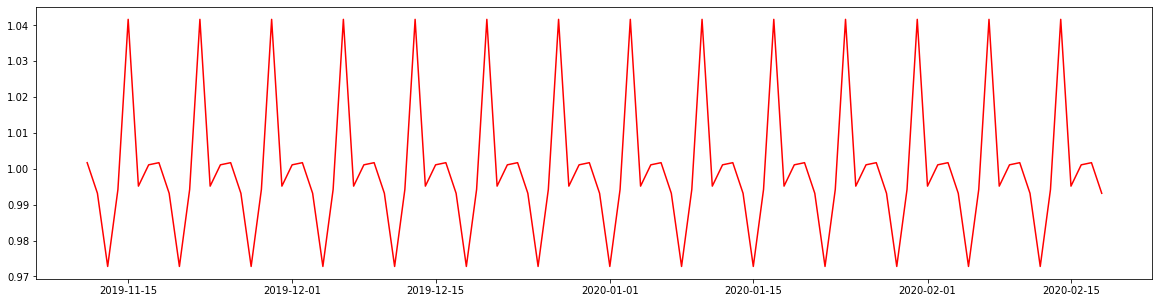

In [11]:
Observar_descomposicion("mín")

In [12]:
def peak(cas):
    part = general[cas]
    result = seasonal_decompose(part, model="multiplicative").seasonal.reset_index(drop = True)
    f, asd = signal.periodogram(result)
    peaks, _ = find_peaks(asd, height=0)
#     plt.plot(1/f, asd)
#     plt.xlim(0, 10)
    return 1/(f[peaks])

In [13]:
peak("mín")

array([6.99881235, 3.49940618, 2.33293745])

In [14]:
def sen_cos(cas):
    t = np.arange(1, len(general.MWh)+1)
    Tiempo = pd.DataFrame(t, columns = ['te'], index = general.index)
    Tiempo["one"] = 1
    picos = peak(cas)
    for ar in picos:
        Tiempo[f'sen_{ar:.2f}']=np.abs(np.sin(((np.pi)/ar)*t))
        Tiempo[f'cos_{ar:.2f}']=np.abs(np.cos(((np.pi)/ar)*t))
    return Tiempo 

In [15]:
def kr_reg_uno(n, cas):
    #Primer kronecker
    Dum = Dumm(); Tiempo = sen_cos(cas); y = get_y(cas)
    Combinacion1 = kronecker(Dum, Tiempo)
    Combinacion = pd.concat([Combinacion1,  Dum, Tiempo], axis = 1)
    #Modelo 
    model = LinearRegression(n_jobs = -1).fit(Combinacion[:-n], y.values[:-n])
    prediction = model.predict(Combinacion[:-n])
    comp=comparacion(y.values[:-n],prediction)
    return comp

In [16]:
bob = kr_reg_uno(7, "mín")
pd.concat([bob.real, bob.prediccion], axis = 1).iplot()
bob.error.mean()

7.5331389710528125

# Error

In [17]:
(bob.real - bob.prediccion).iplot()

Periodicidades ocultas

In [18]:
def residuales(n, cas):
    aba = kr_reg_uno(n , cas)
    f, asd = signal.periodogram(aba.real - aba.prediccion)
    pico , _ = find_peaks(asd)
#     pd.DataFrame(asd, 1/f).iplot()
    return 1/(f[pico])[:12]

In [19]:
def sen_cos_dos(n, cas):
    t = np.arange(1, len(general.MWh)+1)
    Tiempo = pd.DataFrame(index = general.index)
#     Tiempo["one"] = 1
    picos = residuales(n, cas)
    for ar in picos:
        Tiempo[f'sen_{ar:.2f}']=np.abs(np.sin(((np.pi)/ar)*t))
        Tiempo[f'cos_{ar:.2f}']=np.abs(np.cos(((np.pi)/ar)*t))
    return Tiempo

In [20]:
def reg_2(n, cas):
    Dum = Dumm(); Tiempo = sen_cos(cas); Tiempo1 = sen_cos_dos(n, cas); y = get_y(cas)
    Tiempos = pd.concat([Tiempo, Tiempo1], axis = 1)
    Combinacion1 = kronecker(Tiempos, Dum)
    Combinacion = pd.concat([Combinacion1, Tiempos, Dum], axis = 1)
    
#     #Modelo
    model = LinearRegression(n_jobs = -1).fit(Combinacion[:-n], y.values[:-n])
    prediction = model.predict(Combinacion[:-n])
    comp = comparacion(y.values[:-n], prediction)
    return comp

In [21]:
barbara = reg_2(7, "mín")

In [22]:
pd.concat([barbara.real, barbara.prediccion], axis = 1).iplot()
barbara.error.mean()

3.1804823568457974

# Forcasting

In [23]:
def kr_reg(n, cas):
    #Primer kronecker
    Dum = Dumm(); Tiempo = sen_cos(cas); Tiempo1 = sen_cos_dos(n, cas); y = get_y(cas)
    Tiempos = pd.concat([Tiempo, Tiempo1], axis = 1)
    Combinacion1 = kronecker(Dum, Tiempos)
    Combinacion = pd.concat([Combinacion1, Dum, Tiempo], axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(Combinacion, y, test_size = n, shuffle = False)
    #Modelo 
    model = LinearRegression(n_jobs = -1).fit(X_train, y_train).predict(X_test)
#     model1 = AR(y_train, 3.5).fit().predict(start=len(y_train), end=len(y_train) + len(y_test)-1, dynamic=False)
    model2 = Lasso(normalize = True).fit(X_train, y_train).predict(X_test)
    model3 = Ridge(normalize = True).fit(X_train, y_train).predict(X_test)
    model4 = XGBRegressor(objective ='reg:squarederror', n_jobs=-1, fit_intercept=False, normalize = True)\
    .fit(X_train, y_train).predict(X_test)
    
    co = ["y", "y_li", "y_las", "y_rid", "y_xgb"]
    dict_cal = {key:value for (key,value) in zip(co, [y_test, model, model2, model3, model4])}
    models = pd.DataFrame(dict_cal)
    
#     prediction = model.predict(Combinacion.tail(n))
#     comp=comparacion(y.tail(n),prediction)
    return models

In [24]:
def graf_hole(n, ca):
    mod = kr_reg(n, ca)
    ma = pd.DataFrame()
    for i in mod.columns[1:]:
        ma[f"ma_{i[2:]}"] = (abs((mod.y - mod[i])/mod.y))
    ma = ma.mean()*100
    mod.iplot(title = str([f"{i}_{j:.1f}" for i, j in zip(ma.keys(), ma.values)]))

In [28]:
graf_hole(7, "mín")

In [194]:
bab = kr_reg(7, "mín")

In [27]:
def graf_hole(n, ca):
    mod = kr_reg(n, ca)
    ma = pd.DataFrame()
    for i in mod.columns[1:]:
        ma[f"ma_{i[2:]}"] = mod.y - mod[i]
        ma[f"ma_{i[2:]}"] = (abs((mod.y - mod[i])/mod.y))
    ma = ma.mean()*100
    mod.iplot(title = str([f"{i}_{j:.1f}" for i, j in zip(ma.keys(), ma.values)]))

In [28]:
graf_hole(7, "mín")

In [200]:
graf_hole(30, "mín")